# Train Network for feature extraction

Feed MFCC values for each song to and encoder-decoder network.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

import cPickle
import numpy as np

from keras import backend as K
from keras.models import Sequential, model_from_yaml
from keras.layers.recurrent import LSTM
from keras.layers.core import Activation, Dense, Dropout, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.preprocessing import sequence
import yaml
import os

## Read data
Pad items with max length of 150

X.shape = (N, 150, 20)

In [3]:
# Read data
config = yaml.load(open(os.path.join(os.path.expanduser("~"), ".blackbird", "config.yaml")).read())
seq_features = cPickle.load(open(config["data"]["features"], "rb"))
weights_file = config["data"]["model"]["weights"]
arch_file = config["data"]["model"]["arch"]
output_layer = int(config["data"]["model"]["output"])

maxlen = 150

X = np.empty((len(seq_features), maxlen, 20))

for idx, key in enumerate(seq_features):
    X[idx, :, :] = sequence.pad_sequences(seq_features[key], maxlen=maxlen, dtype="float32").T

## Train
Reconstruct sequences from a dense vector of size 20

In [3]:
# Create model

model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(maxlen, 20), go_backwards=True))
model.add(Dropout(0.5))
model.add(Dense(20))
model.add(Activation("tanh"))
model.add(RepeatVector(maxlen))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True, go_backwards=True))
model.add(TimeDistributed(Dense(20)))

model.compile(loss="mse", optimizer="adam")

In [4]:
# Train
history = model.fit(X, X, batch_size=128, nb_epoch=500, validation_split=0.2, verbose=1)

Train on 1660 samples, validate on 415 samples
Epoch 1/500
1660/1660 [==============================] - 7s - loss: 1253.6833 - val_loss: 1484.2234
Epoch 2/500
1660/1660 [==============================] - 7s - loss: 1227.0912 - val_loss: 1451.2801
Epoch 3/500
1660/1660 [==============================] - 7s - loss: 1197.5754 - val_loss: 1417.8812
Epoch 4/500
1660/1660 [==============================] - 7s - loss: 1171.0281 - val_loss: 1394.0141
Epoch 5/500
1660/1660 [==============================] - 7s - loss: 1152.0699 - val_loss: 1374.5799
Epoch 6/500
1660/1660 [==============================] - 7s - loss: 1136.8285 - val_loss: 1359.1701
Epoch 7/500
1660/1660 [==============================] - 7s - loss: 1124.0107 - val_loss: 1345.0255
Epoch 8/500
1660/1660 [==============================] - 7s - loss: 1112.1453 - val_loss: 1331.8220
Epoch 9/500
1660/1660 [==============================] - 7s - loss: 1101.0485 - val_loss: 1319.2158
Epoch 10/500
1660/1660 [=============================

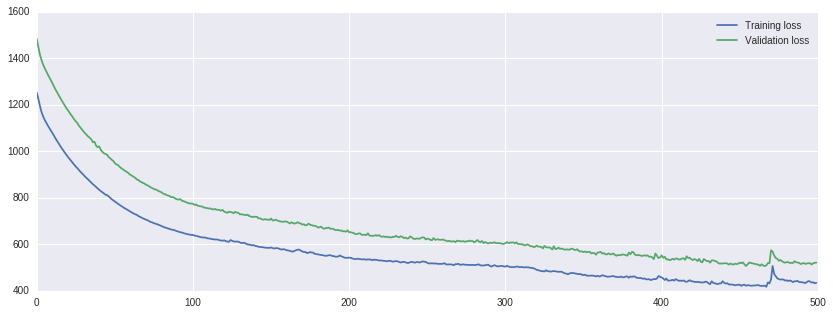

In [5]:
# Use the validation loss curve to stop at a good solution
plt.figure(figsize=(14, 5))
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.legend()
plt.show()

In [6]:
# Save architecture and weights
if os.path.isfile(weights_file):
    os.rename(weights_file, weights_file + ".backup")
if os.path.isfile(arch_file):
    os.rename(arch_file, arch_file + ".backup")

# Save things
open(arch_file, "w").write(model.to_yaml())
model.save_weights(weights_file)

## Load previous model

In [4]:
# Load model
model = model_from_yaml(open(arch_file).read())
model.load_weights(weights_file)

In [18]:
# Function to predict output
predict = K.function([model.layers[0].input, K.learning_phase()],
                      model.layers[output_layer].output)

In [22]:
# Predict output
test_X = predict([X, 0])